# Deep Learning Course: Lab Exercises

In this lab exercise you will:

a) Learn about Generative Adversarial Networks to generate fake images of MNIST digits.

b) Implement Generator and Discriminator networks

c) Learn training and evaluating a GAN.

d) Learn about mode collapse (hard to achieve intentionally, occurs when you don't want)

e) Try out DCGAN on your own



In [1]:
### Connect to Google Drive if you are using Drive.

In [2]:
### Import all your libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# CPU or GPU device ?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


## a) MNIST Dataset

In [4]:
## load train, test and validation label arrays
##here put your custom destination folder

bs = 128     # batch size

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
# *****START CODE
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
# *****END CODE

100%|██████████| 9912422/9912422 [00:00<00:00, 108004008.99it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112058921.21it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42725237.05it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## b) Implement Generator and Discriminator networks

### Generator Class

The Generator is a neural network that takes as input a noise vector and outputs a generated fake image of size 784 (28*28).

In [5]:
## Generator and Discriminator networks

class Generator(nn.Module):
    ###
    # Complete the following generator class initializer with
    # 4 linear layers using leaky ReLU (negative slope equal to 0.2) and each block doubles the size of hidden_dim
    ###
    def __init__(self, g_input_dim, g_output_dim, hidden_dim=256):
        super(Generator, self).__init__()

        # *****START CODE
        self.fc1 = nn.Linear(g_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, g_output_dim)
        # *****END CODE

    # forward method
    def forward(self, x):
        # *****START CODE
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
        # *****END CODE


### Discriminator Class

The discriminator takes as input an image and outputs a 1 dimensional tensor representing fake/real.

In [6]:
class Discriminator(nn.Module):
    ###
    # Complete the following discriminator class initializer with
    # 4 linear layers using leaky ReLU (negative slope equal to 0.2)
    # each block doubles the size of hidden_dim from the end
    # each block applies dropout with p=0.3
    ###
    def __init__(self, d_input_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        # *****START CODE
        self.fc1 = nn.Linear(d_input_dim, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        # *****END CODE

    # forward method
    def forward(self, x):
        # *****START CODE
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc4(x)
        # *****END CODE

## c) Learn training and evaluating a GAN.

In [7]:
## Initialize networks

z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)
print(mnist_dim)

# *****START CODE
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)
# *****END CODE

784


In [8]:
## Print networks
# *****START CODE
print(G)
print(D)
# *****END CODE

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [9]:
## Initialize loss and optimizers
# *****START CODE
# loss
criterion = nn.BCEWithLogitsLoss()

# optimizer
lr = 2e-4
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)
# *****END CODE

In [10]:
## Define Generator and Discriminator training loop

def G_train(x):
    ###
    #     Complete the following steps:
    #       1) Create noise vectors and generate a batch of fake images.
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #      Again do not write your own loss function here - use criterion(..., ...)
    ###
    #=======================Train the generator=======================#
    # *****START CODE
    G.zero_grad()

    z = torch.randn(x.shape[0], z_dim).to(device)
    y = torch.ones(x.shape[0], 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()
    # *****END CODE


def D_train(x):
    ###
    #     Complete this function with the following:
    #       1) Create noise vectors and generate a batch (num_images) of fake images.
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a
    #            'ground truth' tensor in order to calculate the loss.
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #          Do not write your own loss function, use criterion(..., ...)
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to D_loss.
    ###
    #=======================Train the discriminator=======================#
    # *****START CODE
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(x.shape[0], 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_real_score = D(x_real)
    D_real_loss = criterion(D_real_score, y_real)

    # train discriminator on fake
    z = torch.randn(x.shape[0], z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(x.shape[0], 1).to(device)

    D_fake_score = D(x_fake.detach())
    D_fake_loss = criterion(D_fake_score, y_fake)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()
    # *****END CODE

In [11]:
# Train Generator and Discriminator networks
D_losses, G_losses = [], []
n_epoch = 100
for epoch in range(1, n_epoch+1):
    D_losses_cur, G_losses_cur = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses_cur.append(D_train(x))
        G_losses_cur.append(G_train(x))
    D_losses_epoch = np.mean(D_losses_cur)
    G_losses_epoch = np.mean(G_losses_cur)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, D_losses_epoch, G_losses_epoch))
    D_losses.append(D_losses_epoch)
    G_losses.append(G_losses_epoch)

[1/100]: loss_d: 1.131, loss_g: 1.833
[2/100]: loss_d: 1.287, loss_g: 1.011
[3/100]: loss_d: 1.253, loss_g: 1.437
[4/100]: loss_d: 1.116, loss_g: 1.885
[5/100]: loss_d: 0.766, loss_g: 2.168
[6/100]: loss_d: 0.534, loss_g: 2.715
[7/100]: loss_d: 0.524, loss_g: 2.842
[8/100]: loss_d: 0.555, loss_g: 2.762
[9/100]: loss_d: 0.500, loss_g: 2.791
[10/100]: loss_d: 0.521, loss_g: 2.730
[11/100]: loss_d: 0.547, loss_g: 2.833
[12/100]: loss_d: 0.540, loss_g: 2.674
[13/100]: loss_d: 0.616, loss_g: 2.412
[14/100]: loss_d: 0.629, loss_g: 2.341
[15/100]: loss_d: 0.664, loss_g: 2.288
[16/100]: loss_d: 0.646, loss_g: 2.253
[17/100]: loss_d: 0.718, loss_g: 2.137
[18/100]: loss_d: 0.722, loss_g: 2.090
[19/100]: loss_d: 0.772, loss_g: 1.999
[20/100]: loss_d: 0.744, loss_g: 1.999
[21/100]: loss_d: 0.774, loss_g: 1.935
[22/100]: loss_d: 0.824, loss_g: 1.802
[23/100]: loss_d: 0.822, loss_g: 1.790
[24/100]: loss_d: 0.862, loss_g: 1.709
[25/100]: loss_d: 0.895, loss_g: 1.633
[26/100]: loss_d: 0.901, loss_g: 1

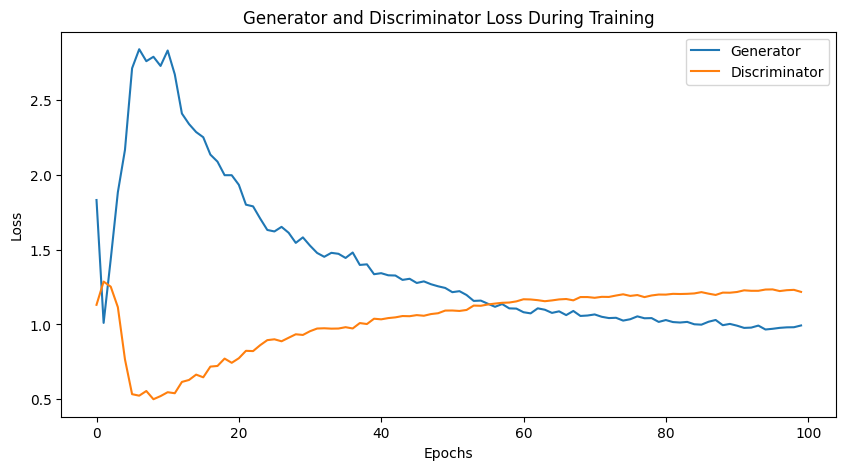

In [12]:
# Plot train losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

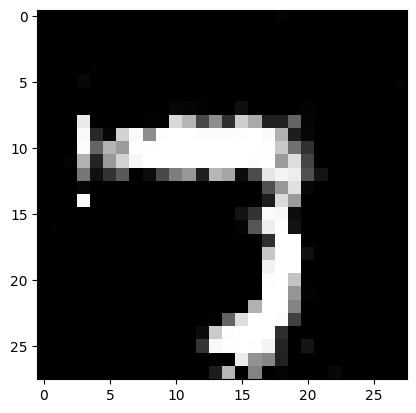

In [13]:
# Generate samples
img_list=[]
with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)
    generated = generated.view(generated.size(0), 1, 28, 28)
    generated = generated.data.cpu()
    img_list.append(vutils.make_grid(generated[:64], padding=2, normalize=True))
    plt.imshow(generated[0][0].numpy(), cmap="gray")

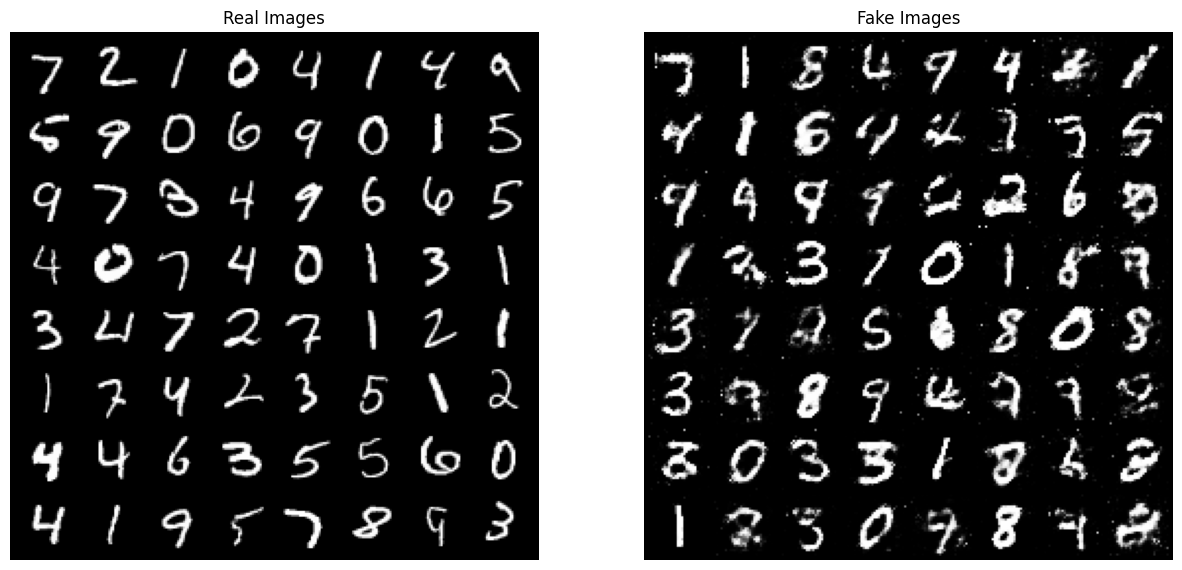

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(test_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## d) Learn about mode collapse (if it did not happen yet)

#### Question:
The following graph plots the generator's and discriminator's losses during the training of a GAN. Why does the Generator's loss go up after approximately 3000 iterations ?

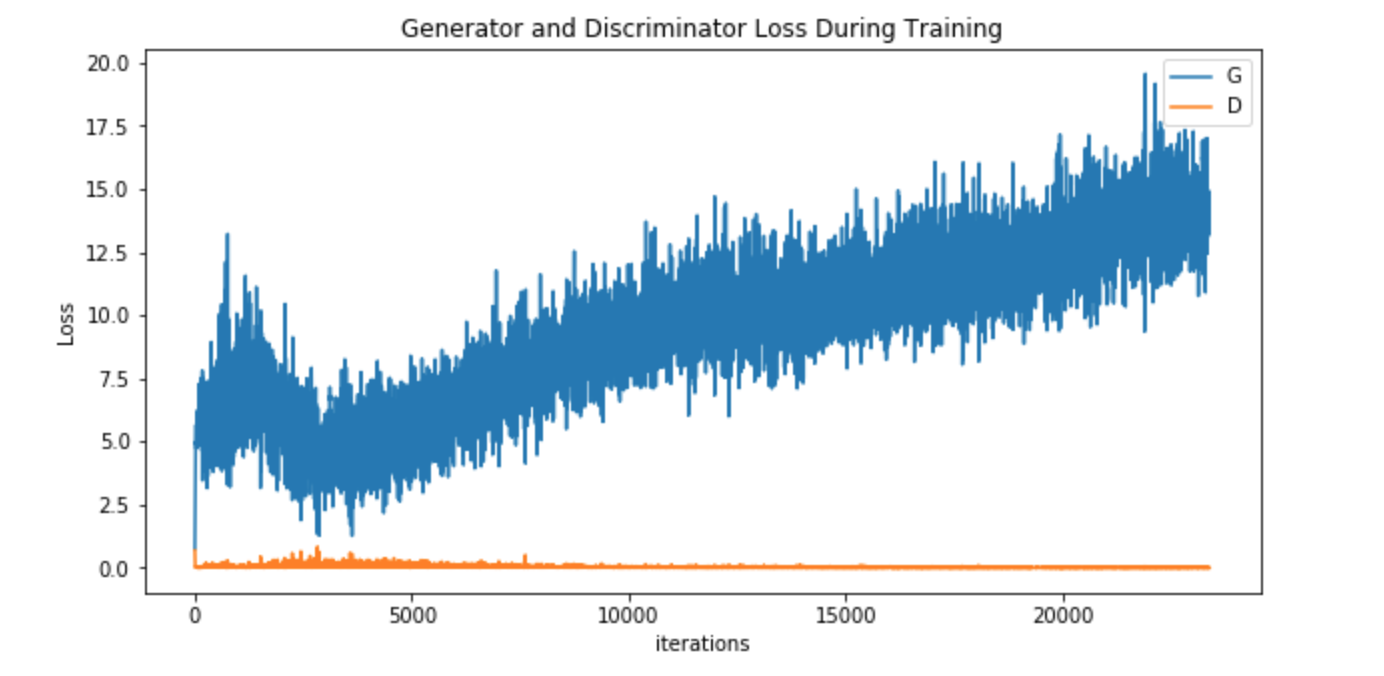




## e) Try out DCGAN on your own

1) Create your own Generator or Discriminator convolutional network or

2) Google DCGAN networks and copy the Generator and Discriminator network

3) Modify training loops from Linear GAN to make it work for DCGAN networks

4) Ask for help, if you get stuck



In [15]:
### DCGAN

class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(DCGenerator, self).__init__()
      # *****START CODE
      self.network = nn.Sequential( # input is Z, going into a convolution
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
            # state size. (ngf*2) x  x
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
            # state size. (ngf) x  x
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          # state size. (nc) x  x
      )
      # *****END CODE

    def forward(self, x):
        # *****START CODE
        x = x.unsqueeze(2).unsqueeze(3)
        output = self.network(x)
        return output
        # *****END CODE

class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(DCDiscriminator, self).__init__()
        # *****START CODE
        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
            )
        # *****END CODE

    def forward(self, input):
        # *****START CODE
        output = self.network(input)
        return output.view(-1, 1)
        # *****END CODE

The default weight initialization provided by PyTorch easily leads to saturation, so we need a custom weight initializer. What is saturation? the state in which a neuron predominantly outputs values close to the asymptotic ends of the bounded activation function.

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [17]:
## Define networks, loss function and optimizer

nc = 1            # 1 for grayscale and 3 for RGB
z_dim = 100       # noise vector size
ngf = 64          # number of features in Generator network
ndf = 64          # number of features in Discriminator network
d_lr = 2e-4       # Discriminator learning rate
g_lr = 2e-4       # Generator learning rate
bs = 128          # batch size
num_epochs = 50    # epochs

In [18]:
# Data Loader (Input Pipeline)
# *****START CODE
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
# *****END CODE

In [19]:
# *****START CODE
# Define Discriminator and Generator architectures
G = DCGenerator(nc, z_dim, ngf).to(device)
G.apply(weights_init)
D = DCDiscriminator(nc, ndf).to(device)
D.apply(weights_init)

# loss function
criterion = nn.BCEWithLogitsLoss()

# optimizers (use Adam and betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=d_lr, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=g_lr, betas=(0.5, 0.999))
# *****START CODE

In [20]:
## Print networks
# *****START CODE
print(G)
print(D)
# *****END CODE

DCGenerator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
DCDiscriminator(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_s

In [21]:
## Define Generator and Discriminator training loop


def G_train(x):
    #=======================Train the generator=======================#
    # *****START CODE
    G.zero_grad()

    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()
    # *****END CODE


def D_train(x):
    #=======================Train the discriminator=======================#
    # *****START CODE
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)

    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake.detach())
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()
    # *****END CODE

In [22]:
# Train Generator and Discriminator networks
D_losses, G_losses = [], []
for epoch in range(1, num_epochs+1):
    D_losses_cur, G_losses_cur = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses_cur.append(D_train(x))
        G_losses_cur.append(G_train(x))
    D_losses_epoch = np.mean(D_losses_cur)
    G_losses_epoch = np.mean(G_losses_cur)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), num_epochs, D_losses_epoch, G_losses_epoch))
    D_losses.append(D_losses_epoch)
    G_losses.append(G_losses_epoch)

[1/50]: loss_d: 0.370, loss_g: 3.200
[2/50]: loss_d: 0.475, loss_g: 2.602
[3/50]: loss_d: 0.586, loss_g: 2.116
[4/50]: loss_d: 0.632, loss_g: 1.954
[5/50]: loss_d: 0.586, loss_g: 2.031
[6/50]: loss_d: 0.598, loss_g: 2.024
[7/50]: loss_d: 0.548, loss_g: 2.163
[8/50]: loss_d: 0.560, loss_g: 2.101
[9/50]: loss_d: 0.539, loss_g: 2.171
[10/50]: loss_d: 0.477, loss_g: 2.347
[11/50]: loss_d: 0.503, loss_g: 2.321
[12/50]: loss_d: 0.464, loss_g: 2.413
[13/50]: loss_d: 0.538, loss_g: 2.321
[14/50]: loss_d: 0.487, loss_g: 2.353
[15/50]: loss_d: 0.419, loss_g: 2.568
[16/50]: loss_d: 0.423, loss_g: 2.579
[17/50]: loss_d: 0.447, loss_g: 2.574
[18/50]: loss_d: 0.470, loss_g: 2.571
[19/50]: loss_d: 0.435, loss_g: 2.587
[20/50]: loss_d: 0.394, loss_g: 2.724
[21/50]: loss_d: 0.369, loss_g: 2.788
[22/50]: loss_d: 0.416, loss_g: 2.701
[23/50]: loss_d: 0.377, loss_g: 2.824
[24/50]: loss_d: 0.399, loss_g: 2.777
[25/50]: loss_d: 0.365, loss_g: 2.874
[26/50]: loss_d: 0.368, loss_g: 2.921
[27/50]: loss_d: 0.36

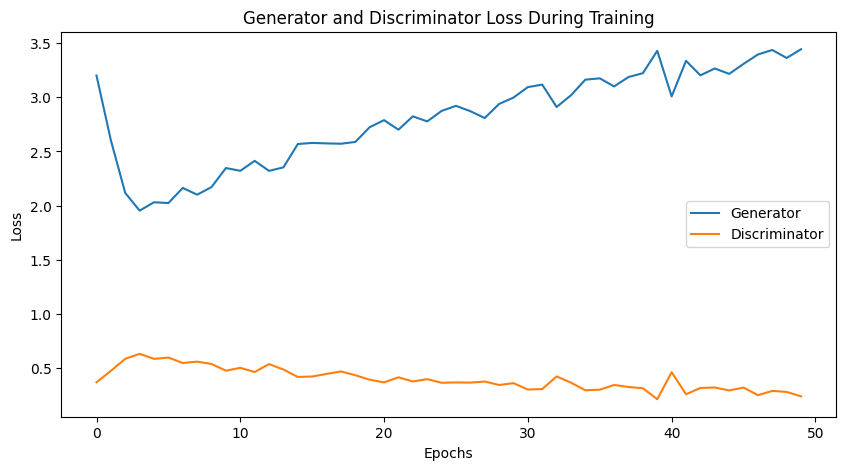

In [23]:
# Plot train losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

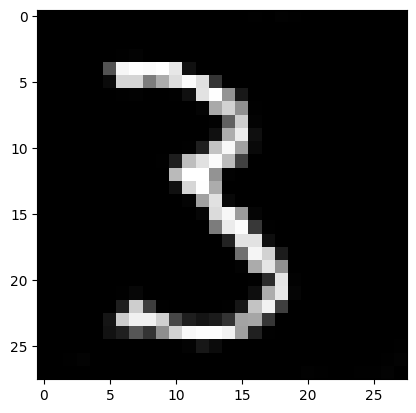

In [24]:
# Generate samples
img_list=[]
with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)
    generated = generated.data.cpu()
    img_list.append(vutils.make_grid(generated[:64], padding=2, normalize=True))
    plt.imshow(generated[0][0].numpy(), cmap="gray")

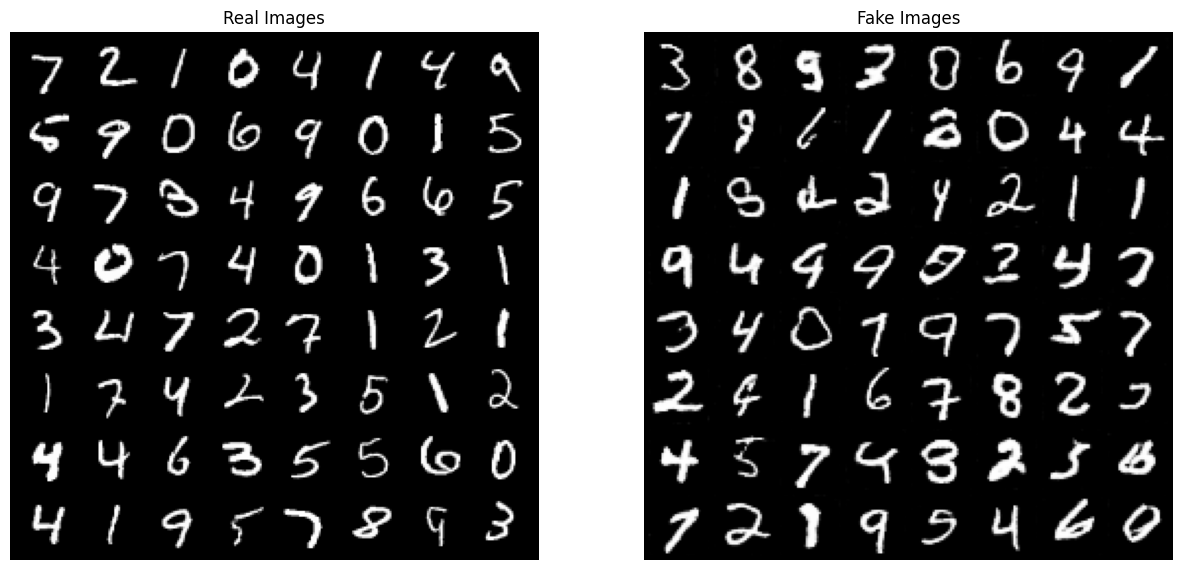

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(test_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()